In [2]:
from pymongo import MongoClient
from tweets_utils import *
from langdetect import detect
import re
import time
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from operator import itemgetter
from tqdm import tqdm_notebook
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(10,10)
import numpy as np
from frozendict import frozendict
from os import listdir, makedirs
from os.path import isfile, join
from slugify import slugify
import jellyfish

In [3]:
client = MongoClient()
db = client.search_subject
real_urls_collection = db.real_urls

In [4]:
pool_query = {"txt_lang": "en", "state": {"$in": ["bowed18", "bowed17"]}, "txt_len": {"$gt": 350}}
attributes = {"clean_content", "txt_lang", "state", "txt_title"}

In [5]:
all_urls = real_urls_collection.find(pool_query)
print("Nb URLS:", all_urls.count())
clean_urls = []
for u in all_urls:
    cu = {k: u[k] for k in attributes}
    cu["url"] = u["_id"]["real_url"]
    cu["filename"] = u["filename"].split('.')[0]
    clean_urls.append(cu)

Nb URLS: 1181


In [6]:
extracted = "datas/cleaned/"
groups_path = "datas/groups/"

min_paragraph_length = 50

min_prefix_matches = 4
min_match_len = 1500

In [7]:
def create_pdict(u):
    page_dict = {}
    for line in u["clean_content"].split("\n"):
        # Remove spaces around the line.
        line = line.strip()
        line_len = len(line)
        
        if line_len < min_paragraph_length: continue

        prefix = line[0:40]
        page_dict[prefix] = line_len
        # print(i, u["url"], ":", len(page_dict))

    return page_dict

In [8]:
pages = {}  # pages[filename] is a dict of (paragraph beginning: length)
n = 0
for i, u in enumerate(clean_urls):
    n += 1
    u["page_dict"] = frozendict(create_pdict(u))

In [177]:
def pd_dist(u1, u2):
    inter = frozenset(set(u1["page_dict"]) & set(u2["page_dict"]))
    nb_matches = len(inter)
    len_matched = sum([min(u1["page_dict"][x], u2["page_dict"][x]) for x in inter])
    
    return nb_matches, len_matched, inter

In [10]:
aa = real_urls_collection.find_one({"_id": {"real_url": "http://salon-des-refuses.org/"}})

In [11]:
print(aa["clean_content"])

as a result of the nips review process we accepted less than 600 papers out of nearly 2500 submissions with a review process of this scale it is unavoidable that among the rejected papers there are hidden gems that simply drowned in the review process for this reason we propose an exhibition of rejected papers in a spirit similar to the salon de refuesés below you can find a list of those rejected nips submissions whose authors decided to take part in the exhibition neither nips nor the program committee provides any warranty about the quality of these papers isabelle guyon and ulrike von luxburg

as the nips experiment showed the consistency of the reviewing process is far from perfect as eric price wrote in a blog post about the experiment in other words most papers at nips would be rejected if one reran the conference review process a hallmark of every good scientist is to always recognise that they may have been mistaken the list below of papers rejected by the review process is an

In [12]:
nb_dupes = 0
seen = set()
ma = set()
for u1 in clean_urls:
    seen.add(u1["url"])
    for u2 in clean_urls:
        if u2["url"] in seen: continue
        c1 = u1["clean_content"]
        c2 = u2["clean_content"]
        ratio = len(c1) / len(c2) 
        if (c1 == c2):# or c1 in c2 or c2 in c1) and ratio < 2 and ratio > 0.5:
            nb_dupes += 1
            #if "cluster_id" not in u1:
            #    print(u1["url"], '\n', u2["url"], '\n')
            ma.add(frozenset({u1["url"], u2["url"]}))

In [13]:
nb_dupes

1329

In [559]:
nb_dupes = 0
seen = set()
results = []
mb = []
for u1 in clean_urls:
    seen.add(u1["url"])
    for u2 in clean_urls:
        if u2["url"] in seen: continue

        nb_matches, len_matched, _ = pd_dist(u1, u2)

        if nb_matches >= min_prefix_matches or len_matched > min_match_len or len_matched > 0.7 * min(len(u1["clean_content"]), len(u2["clean_content"])): 
            
            score_matched_len = min(1, len_matched / (5 * min_match_len))
            score_1_in_2 = len_matched / len(u1["clean_content"])
            score_2_in_1 = len_matched / len(u2["clean_content"])
            score = 3 * score_matched_len + score_1_in_2 + score_2_in_1
            if score > 1.8:
                mb.append(({u1["url"], u2["url"]}, score))#frozendict(u1), frozendict(u2)            
                nb_dupes += 1


print(nb_dupes)
print('DONE')

2382
DONE


In [560]:
import igraph

In [610]:
g = igraph.Graph()

In [611]:
id2urls = [x["url"] for x in clean_urls]

In [612]:
id2labels = [x["url"].split("://")[1].split("?utm")[0] for x in clean_urls]

In [613]:
urls2id = {id2urls[k]: k for k in range(len(clean_urls))}

In [614]:
g.add_vertices(len(id2urls))

In [615]:
g.vs["url"] = id2urls

In [616]:
g.vs["label"] = id2labels

In [617]:
print(g)

IGRAPH U--- 1181 0 --
+ attr: label (v), url (v)


In [618]:
for (pa, pb), w in mb:
    g.add_edge(urls2id[pa], urls2id[pb], lol=5 - w, cou=w, eexp=2.7**(w**2), label=w)
    

In [570]:
g.to_undirected()

In [571]:
comps = g.components()

In [583]:
results = []
for c in comps:
    results.append([clean_urls[k] for k in c])

In [572]:
print(comps.subgraph(5))

IGRAPH U--- 1 0 --
+ attr: label (v), url (v), cou (e), eexp (e), lol (e)


In [573]:
len([x for x in comps if len(x) > 2])

70

In [574]:
vx = g.vs.select(_degree_gt=0)

In [575]:
len(vx)

598

In [576]:
gg = comps.subgraph(347)

In [577]:
print(gg)

IGRAPH U--- 1 0 --
+ attr: label (v), url (v), cou (e), eexp (e), lol (e)


In [578]:
visual_style = {}
visual_style["vertex_size"] = 3
visual_style["edge_width"] = 0.5
visual_style["vertex_label_size"] = 12
visual_style["margin"] = 200
visual_style["bbox"] = (2000, 2000)
visual_style["vertex_label_dist"] = 2

In [579]:
g.is_weighted()

False

In [580]:
comps = g.components()
for i, comp in tqdm_notebook(enumerate(comps)):
    if len(comp) <= 2: continue
    gra = comps.subgraph(i)
    if gra.degree_distribution().mean == gra.vcount() - 1: continue
    #print(gra.degree_distribution().mean, gra.vcount() - 1)
    lay = gra.layout_fruchterman_reingold(weights="cou")
    igraph.plot(gra, layout=lay, **visual_style, target="comps/"+ str(i) + ".png")

In [796]:
print(comps)

Clustering with 1181 elements and 745 clusters
[  0] 0, 138
[  1] 1, 22, 40, 72, 98, 114, 140, 252, 494, 510, 532, 625, 715, 949, 1084,
      1113
[  2] 2
[  3] 3, 116
[  4] 4, 728, 801
[  5] 5
[  6] 6
[  7] 7, 294, 1020, 1115
[  8] 8
[  9] 9, 21, 24, 31, 33, 46, 49, 56, 63, 74, 75, 88, 92, 179, 209, 212, 239,
      280, 315, 394, 431, 449, 484, 542, 565, 579, 585, 589, 619, 630, 635,
      666, 686, 712, 787, 810, 827, 847, 909, 973, 996, 999, 1026, 1034, 1050,
      1108, 1109, 1133
[ 10] 10, 908
[ 11] 11
[ 12] 12, 961, 1053
[ 13] 13, 79, 267
[ 14] 14
[ 15] 15
[ 16] 16, 296, 741
[ 17] 17, 73, 121, 718
[ 18] 18, 66, 125, 266, 282, 432, 516, 605, 710, 856, 868, 1165
[ 19] 19, 384, 561, 578, 793, 921, 1118
[ 20] 20
[ 21] 23
[ 22] 25, 131
[ 23] 26
[ 24] 27
[ 25] 28
[ 26] 29, 1078
[ 27] 30, 89
[ 28] 32, 202, 1086
[ 29] 34
[ 30] 35, 197, 240, 310, 351, 376, 523, 650, 665, 936, 1111, 1156
[ 31] 36, 39, 729
[ 32] 37
[ 33] 38
[ 34] 41
[ 35] 42, 207
[ 36] 43
[ 37] 44
[ 38] 45
[ 39] 47
[ 40] 48

### Test subgraph 30 & 207 (1 outsider node)

In [803]:
sg = comps.subgraph(135) #(30)

In [804]:
print(sg.degree_distribution())

N = 9, mean +- sd: 5.5556 +- 2.1858
[2, 3): ** (2)
[3, 4):  (0)
[4, 5):  (0)
[5, 6):  (0)
[6, 7): ***** (5)
[7, 8):  (0)
[8, 9): ** (2)


In [805]:
vss = {}
vss["vertex_size"] = 5
vss["edge_width"] = 0.5
vss["vertex_label_size"] = 10
vss["margin"] = 200
vss["bbox"] = (600, 600)
vss["vertex_label_dist"] = 2

In [806]:
print(sg)

IGRAPH U--- 9 25 --
+ attr: label (v), url (v), cou (e), eexp (e), lol (e)
+ edges:
0 -- 1 2 3 4 5 7       3 -- 0 1 2 4 5 6 7 8   6 -- 2 3
1 -- 0 2 3 4 5 7       4 -- 0 1 2 3 5 7       7 -- 0 1 2 3 4 5
2 -- 0 1 3 4 5 6 7 8   5 -- 0 1 2 3 4 7       8 -- 2 3


In [807]:
comms = sg.community_leading_eigenvector(weights="lol")

In [808]:
print(comms)

Clustering with 9 elements and 2 clusters
[0] 0, 1, 4, 5, 7
[1] 2, 3, 6, 8


In [809]:
clu = comms.subgraphs()

In [810]:
for c in clu:
    for x in c.vs:
        print(x["url"])
    print()

http://nuit-blanche.blogspot.com/2016/12/spotlight-videos-at-nips2016.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+blogspot%2FvhVI+%28Nuit+Blanche%29
http://nuit-blanche.blogspot.com/2016/12/videos-at-nips2016-and-other-news-and.html
http://nuit-blanche.blogspot.com/2016/12/spotlight-videos-at-nips2016.html
http://nuit-blanche.blogspot.co.id/2016/12/spotlight-videos-at-nips2016.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed:+blogspot/wCeDd+(Nuit+Blanche)&utm_content=Netvibes
http://nuit-blanche.blogspot.com/2016/12/videos-at-nips2016-and-other-news-and.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+blogspot%2FvhVI+%28Nuit+Blanche%29

http://nuit-blanche.blogspot.com/2016/12/what-to-do-in-barcelona-this-week.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+blogspot%2FvhVI+%28Nuit+Blanche%29
http://nuit-blanche.blogspot.com/2016/12/what-to-do-in-barcelona-this-week.html
http://abunchofdata.com/what-to-do-in-barcelo

In [815]:
print(clu[1].degree_distribution())

N = 4, mean +- sd: 2.5000 +- 0.5774
[2, 3): ** (2)
[3, 4): ** (2)


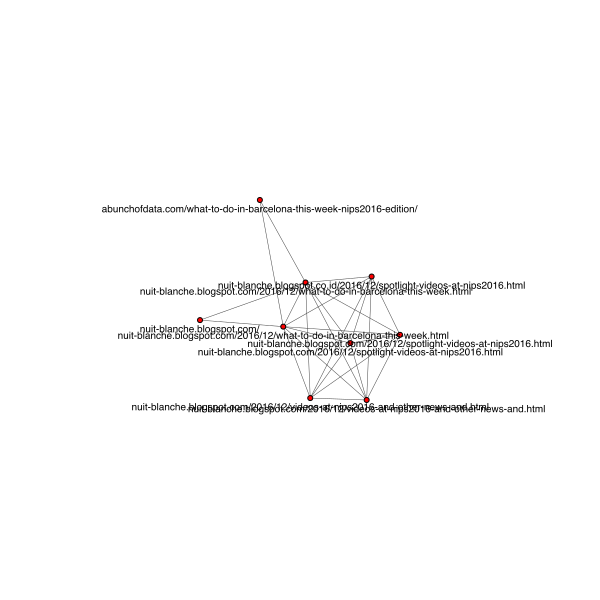

In [811]:
igraph.plot(sg, **vss, target="comps/"+ str(i) + ".png")

In [816]:
outsiders = sg.vs.select(_degree_lt=int((sg.vcount() - 1) * 0.6))

In [817]:
outsiders["url"]

['http://abunchofdata.com/what-to-do-in-barcelona-this-week-nips2016-edition/',
 'http://nuit-blanche.blogspot.com/']

In [229]:
set(sg.vs["url"]) - set(outsiders["url"])

{'http://abunchofdata.com/spotlight-videos-at-nips2016/',
 'http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html',
 'http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html?spref=tw',
 'http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+blogspot%2FvhVI+%28Nuit+Blanche%29',
 'http://nuit-blanche.blogspot.com/2016/12/thesis-uncertainty-in-deep-learning-by.html',
 'http://nuit-blanche.blogspot.com/2016/12/videos-at-nips2016-and-other-news-and.html',
 'http://nuit-blanche.blogspot.com/2016/12/videos-at-nips2016-and-other-news-and.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+blogspot%2FvhVI+%28Nuit+Blanche%29',
 'http://nuit-blanche.blogspot.com/2016/12/what-to-do-in-barcelona-this-week.html',
 'http://nuit-blanche.blogspot.com/2016/12/what-to-do-in-barcelona-this-week.html?utm_source=feedburner&utm_medium=twitter&utm_ca

In [231]:
[x["url"] for x in clean_urls if "barcelona" in x["url"]]

['http://nuit-blanche.blogspot.com/2016/12/what-to-do-in-barcelona-this-week.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+blogspot%2FvhVI+%28Nuit+Blanche%29',
 'https://www.taraslehinevych.me/blog/2016/12/14/nips-barcelona/',
 'http://nuit-blanche.blogspot.com/2016/12/what-to-do-in-barcelona-this-week.html',
 'https://blog.eduardovalle.com/2016/12/06/in-barcelona-for-nips2016/',
 'https://www.audi-mediacenter.com/en/press-releases/automatic-intelligent-parking-audi-at-nips-in-barcelona-7139',
 'http://abunchofdata.com/what-to-do-in-barcelona-this-week-nips2016-edition/']

In [230]:
sorted(sg.vs["url"])

['http://abunchofdata.com/some-general-takeaways-from-nips2016/',
 'http://abunchofdata.com/spotlight-videos-at-nips2016/',
 'http://abunchofdata.com/thesis-uncertainty-in-deep-learning-by-yarin-gal/',
 'http://abunchofdata.com/videos-at-nips2016-and-other-news-and-announcements/',
 'http://abunchofdata.com/what-to-do-in-barcelona-this-week-nips2016-edition/',
 'http://nuit-blanche.blogspot.co.id/2016/12/spotlight-videos-at-nips2016.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed:+blogspot/wCeDd+(Nuit+Blanche)&utm_content=Netvibes',
 'http://nuit-blanche.blogspot.com/',
 'http://nuit-blanche.blogspot.com/2016/08/slides-2016-deep-learning-summer-school.html',
 'http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html',
 'http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html?spref=tw',
 'http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html?utm_source=feedburner&utm_medium=twitter&utm_campaig

In [209]:
dict(clean_urls[urls2id[sg.vs["url"][3]]]["page_dict"])

{'a team of experts from cray microsoft an': 313,
 'at the 2016 neural information processin': 337,
 'by accelerating the training process ins': 147,
 'deep learning problems share algorithmic': 357,
 'running larger deep learning models is a': 443,
 'with the introduction of supercomputing ': 306}

In [210]:
dict(clean_urls[urls2id[sg.vs["url"][2]]]["page_dict"])

{'a team of researchers from microsoft cra': 644,
 'applying a supercomputing approach to op': 380,
 'cray and microsoft accelerate deep learn': 80,
 'cray s proficiency in performance analys': 516,
 'deep learning problems share algorithmic': 357,
 'only cray can bring the combination of s': 522,
 'the result of this deep learning collabo': 206,
 'the team have scaled the microsoft cogni': 239,
 'to simplify the building and deploying o': 465}

In [233]:
[(i, j, pd_dist(clean_urls[urls2id[a]],
        clean_urls[urls2id[b]],
       )) for i, a in enumerate(sg.vs["url"]) for j, b in enumerate(sg.vs["url"]) if i < j]

[(0, 1, (0, 0, frozenset())),
 (0, 2, (0, 0, frozenset())),
 (0, 3, (1, 328, frozenset({'liked this entry subscribe to nuit blanc'}))),
 (0, 4, (0, 0, frozenset())),
 (0, 5, (1, 328, frozenset({'liked this entry subscribe to nuit blanc'}))),
 (0, 6, (1, 328, frozenset({'liked this entry subscribe to nuit blanc'}))),
 (0, 7, (1, 328, frozenset({'liked this entry subscribe to nuit blanc'}))),
 (0, 8, (1, 328, frozenset({'liked this entry subscribe to nuit blanc'}))),
 (0, 9, (0, 0, frozenset())),
 (0, 10, (0, 0, frozenset())),
 (0,
  11,
  (2,
   506,
   frozenset({'also of interest us senate hearings vide',
              'liked this entry subscribe to nuit blanc'}))),
 (0,
  12,
  (2,
   506,
   frozenset({'also of interest us senate hearings vide',
              'liked this entry subscribe to nuit blanc'}))),
 (0, 13, (1, 328, frozenset({'liked this entry subscribe to nuit blanc'}))),
 (0, 14, (1, 328, frozenset({'liked this entry subscribe to nuit blanc'}))),
 (0, 15, (1, 328, frozens

In [159]:
sg.delete_vertices(outsiders)

In [155]:
print(sg.degree_distribution())

N = 13, mean +- sd: 12.0000 +- 0.0000
[12, 13): ************* (13)


In [777]:
nv = 20
h = igraph.Graph()
h.add_vertices(nv)

for i in range(nv):
    for j in range(i+1, nv):
        w1 = 2 if (i < 3 and j < 3) or (i > 16 and j > 16) else 1
        w2 = 1 if (i < 3 and j < 3) or (i > 16 and j > 16) else 2
        h.add_edge(i, j, w1=w1, w2=w2, label=w1)

Ok algos:
- community_optimal_modularity  
- community_multilevel  
- community_leading_eigenvector
- community_fastgreedy (dendogram)

In [788]:
comms = h.community_leading_eigenvector(edge_weights="w1")

In [789]:
print(comms)

Dendrogram, 20 elements, 19 merges

0 1 2 17 18 19 16 3 4 5 6 7 8 9 10 11 12 13 14 15
| | | |  |  |  |  | | | | | | | |  |  |  |  |  |
`-' | |  |  |  |  | | | | | | | |  |  |  |  |  |
 |  | |  |  |  |  | | | | | | | |  |  |  |  |  |
 `--' `--'  |  |  | | | | | | | |  |  |  |  |  |
  |    |    |  |  | | | | | | | |  |  |  |  |  |
  |    `----'  `--' | | | | | | |  |  |  |  |  |
  |      |      |   | | | | | | |  |  |  |  |  |
  |      |      `---' | | | | | |  |  |  |  |  |
  |      |        |   | | | | | |  |  |  |  |  |
  |      |        `---' | | | | |  |  |  |  |  |
  |      |          |   | | | | |  |  |  |  |  |
  |      |          `---' | | | |  |  |  |  |  |
  |      |            |   | | | |  |  |  |  |  |
  |      |            `---' | | |  |  |  |  |  |
  |      |              |   | | |  |  |  |  |  |
  |      |              `---' | |  |  |  |  |  |
  |      |                |   | |  |  |  |  |  |
  |      |                `---' |  |  |  |  |  |
  |      |                  |   

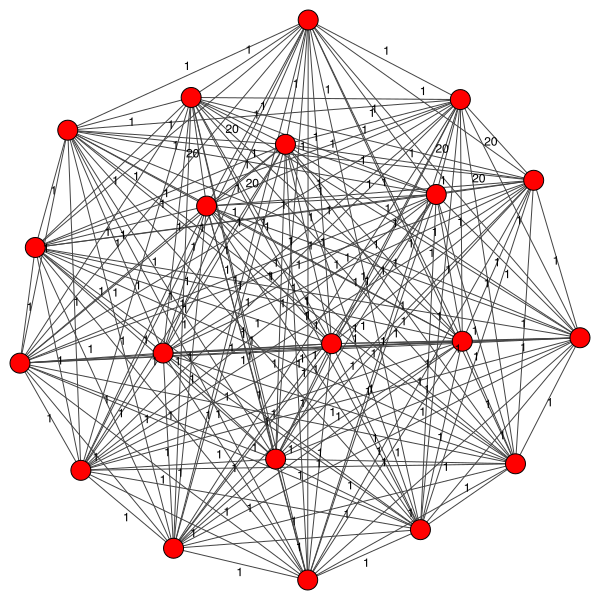

In [766]:
igraph.plot(h, layout=h.layout_fruchterman_reingold(weights="w1"), target="lol.png")

### Whole graph:

In [53]:
layout = g.layout_kamada_kawai()

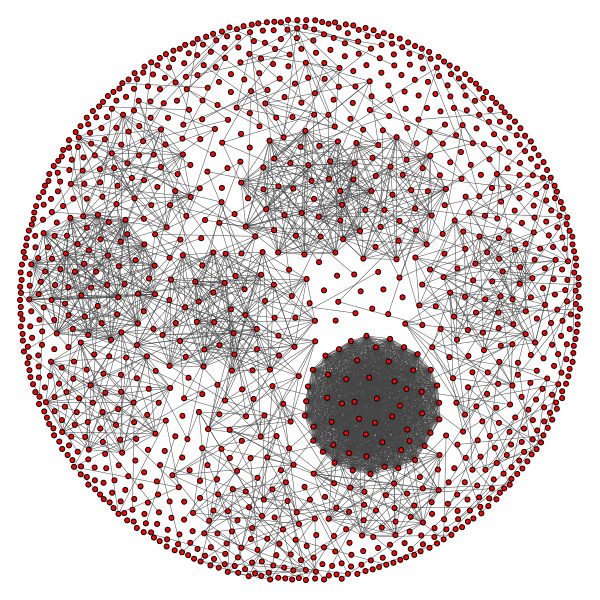

In [56]:
igraph.plot(g, layout=layout, **visual_style)

In [44]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(1329, 2476, 1329, 0, 1147)

In [15]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(2658, 4952, 2658, 0, 2294)

In [257]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(1536, 4914, 1536, 0, 3378)

In [75]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(3769, 5643, 3539, 230, 2104)

In [72]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(3769, 7011, 3769, 0, 3242)

In [64]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(3460, 5643, 3459, 1, 2184)

In [62]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(3510, 5643, 3482, 28, 2161)

In [59]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(3684, 5643, 3528, 156, 2115)

In [57]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(3769, 5643, 3539, 230, 2104)

In [53]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(3858, 5643, 3618, 240, 2025)

In [51]:
len(ma), len(mb), len(ma & mb), len(ma - mb), len(mb - ma)

(89, 5643, 79, 10, 5564)

Print clusters and save to `datas/groups` folders

In [24]:
len(clean_urls) - sum(len(c) for c in results)

705

In [31]:
len(clean_urls) - sum(len(c) for c in results)

684

In [584]:
with open("urls-cluster.html", 'w') as f:
    f.write('<p>')
    for i, group in enumerate(results):
        f.write(str(i) + "<br/>")
        for link in group:
            f.write(str(link["txt_title"]) + "<br/>")
            f.write("<a href={}>{}</a><br/>".format(link["url"], link["url"]))
        f.write('<br/><br/><br/>')
    f.write('</p>')

In [51]:
for i, clus in enumerate(results):
    for u in clus:
        real_urls_collection.update_one({"_id": dict(real_url=u["url"])}, {"$set": {"cluster_id": i}})

In [30]:
nb = list(results[17])

In [287]:
dd = [[pd_dist(a, b)[1] if a!=b else 0 for a in nb] for b in nb]

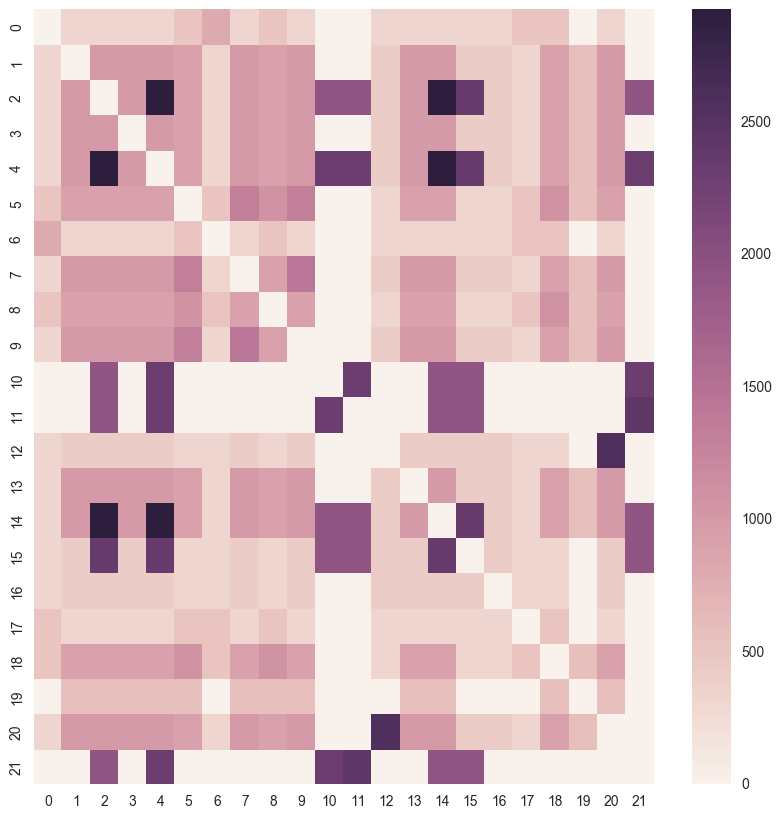

In [288]:
sns.heatmap(dd)

In [31]:
tk = list(results[26])

In [32]:
({x["url"] for x in tk} & {x["url"] for x in nb})

{'http://abunchofdata.com/some-general-takeaways-from-nips2016/',
 'http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html',
 'http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html?spref=tw',
 'http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+blogspot%2FvhVI+%28Nuit+Blanche%29',
 'https://medium.com/@IgorCarron/some-general-take-aways-from-nips2016-c3c5ec23bf1a#.ve4lqrknz',
 'https://medium.com/@IgorCarron/some-general-take-aways-from-nips2016-c3c5ec23bf1a?utm_content=bufferaab56&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer#.6i12hasm3',
 'https://www.linkedin.com/pulse/some-general-take-aways-from-nips2016-igor-carron'}

In [294]:
for uu, c in sorted([(x["url"], "A") for x in tk] + [(x["url"], "B") for x in nb]):
    print(c, '\t', uu)

A 	 http://abunchofdata.com/some-general-takeaways-from-nips2016/
B 	 http://abunchofdata.com/some-general-takeaways-from-nips2016/
B 	 http://abunchofdata.com/spotlight-videos-at-nips2016/
B 	 http://abunchofdata.com/thesis-uncertainty-in-deep-learning-by-yarin-gal/
B 	 http://abunchofdata.com/videos-at-nips2016-and-other-news-and-announcements/
B 	 http://nuit-blanche.blogspot.co.id/2016/12/spotlight-videos-at-nips2016.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed:+blogspot/wCeDd+(Nuit+Blanche)&utm_content=Netvibes
B 	 http://nuit-blanche.blogspot.com/
B 	 http://nuit-blanche.blogspot.com/2016/08/slides-2016-deep-learning-summer-school.html
A 	 http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html
B 	 http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html
A 	 http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html?spref=tw
B 	 http://nuit-blanche.blogspot.com/2016/12/some-general-takeaw

In [291]:
for x in nb:
    print(x["url"])

https://topdata.news/videos-at-nips2016-and-other-news-and-announcements-machinelearning-iot-ai-bigdata/
http://nuit-blanche.blogspot.com/2016/08/slides-2016-deep-learning-summer-school.html
http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html
http://nuit-blanche.blogspot.com/2016/12/spotlight-videos-at-nips2016.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+blogspot%2FvhVI+%28Nuit+Blanche%29
http://nuit-blanche.blogspot.com/2016/12/some-general-takeaways-from-nips2016.html?spref=tw
http://nuit-blanche.blogspot.com/
https://topdata.news/videos-at-nips2016-and-other-news-and-announcements-machinelearning-iot-ai-bigdata/?utm_content=buffer813c5&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer
http://nuit-blanche.blogspot.com/2016/12/what-to-do-in-barcelona-this-week.html
http://nuit-blanche.blogspot.com/2016/12/videos-at-nips2016-and-other-news-and.html
http://nuit-blanche.blogspot.com/2016/12/what-to-do-in-barcelona-this-week

In [290]:
print(dict(nb[0])["url"])
print(dict(nb[6])["url"])

https://topdata.news/videos-at-nips2016-and-other-news-and-announcements-machinelearning-iot-ai-bigdata/
https://topdata.news/videos-at-nips2016-and-other-news-and-announcements-machinelearning-iot-ai-bigdata/?utm_content=buffer813c5&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer
